In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

this has currently the following problems:
- the errors from the fits are underestimated and weirdly do not depend on the parameter std passed to curve_fit
- the alpha parameter in the first two fits is underestimated by a factor of two, but in the final fit is more or less correctly estimated
- the critical point is over estimated by a factor of two
- the first fit gives a terrible estimate of the first parameter
We should re measure the inductance and capacitance.

In [99]:
#equazioni sempre valide:

#induttanza
L = 53.61e-3/2
#resistenza induttanza
r_L = 0.852

L:  301.309979206352442e-3
C: 25.897092684151668e-09

#frequenza
f = 400

# forse non è questa? C = 47.3e-10
C = 32.92e-9

w0 = 1/np.sqrt(L*C)
print("critical regime is hit when R = ", 2*np.sqrt(L/C))
#Time - V_0	Amplitude - V_0	Time - V_L	Amplitude - V_L	Time - V_C	Amplitude - V_C	Time - V_R	Amplitude - V_R

critical regime is hit when R =  1804.7123411405166


the standard deviation is: 0.0013156897386523486


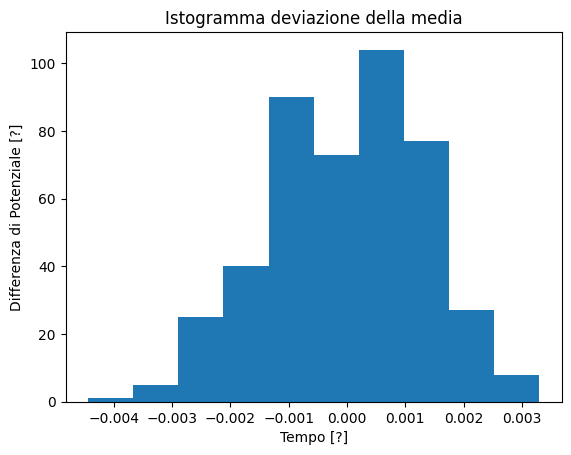

In [100]:
#gaussian fit to evaluate errors
file = "./data/RLC_statico_per_incertezze.txt"

temp = np.loadtxt(file, unpack = True)
data = temp[1]

#removing first values, when it was reaching steady state
data = data[50:]

mean = np.mean(data)
std = np.std(data)

n_bins = 10

fig, axes = plt.subplots()
plt.hist(data-mean, bins = n_bins)

plt.xlabel("Tempo [?]")
plt.ylabel("Differenza di Potenziale [?]")
plt.title("Istogramma deviazione della media")

print("the standard deviation is:", std)

In [101]:
#super over damped :)
R = 7413

index: 0.001
parameters:
 [ 1.31845397e+02 -9.14220711e+03  1.48572591e+00  2.10162374e+00
  7.23055556e-05]
covariance matrix:
 [[ 6.17449261e+02  3.69827579e+03  1.06053710e+04 -1.04028965e+06
   5.41437813e+01]
 [ 3.69827579e+03  4.09918766e+04  1.91465388e+05 -1.87802921e+07
   9.77454301e+02]
 [ 1.06053710e+04  1.91465388e+05  3.63236880e+07 -3.56280844e+09
   1.85432757e+05]
 [-1.04028965e+06 -1.87802921e+07 -3.56280844e+09  3.49458018e+11
  -1.81881694e+07]
 [ 5.41437813e+01  9.77454301e+02  1.85432757e+05 -1.81881694e+07
   9.46635903e+02]]
expected value parameter s1:  -12809.020063542775 
value extracted from fit:  131.84539668602795  +/-  24.848526327664054
expected value parameter s2:  -88472.53188572043 
value extracted from fit:  -9142.20710782898  +/-  202.46450694426957


/var/folders/bd/5ss8qyms4cd6_t67dg1pjhbw0000gn/T/ipykernel_7836/3828700451.py:10: RuntimeWarning: overflow encountered in exp
  return  a1*np.exp(p1*(x-offset)) + a2*np.exp(p2*(x-offset))
/var/folders/bd/5ss8qyms4cd6_t67dg1pjhbw0000gn/T/ipykernel_7836/3828700451.py:10: RuntimeWarning: overflow encountered in multiply
  return  a1*np.exp(p1*(x-offset)) + a2*np.exp(p2*(x-offset))


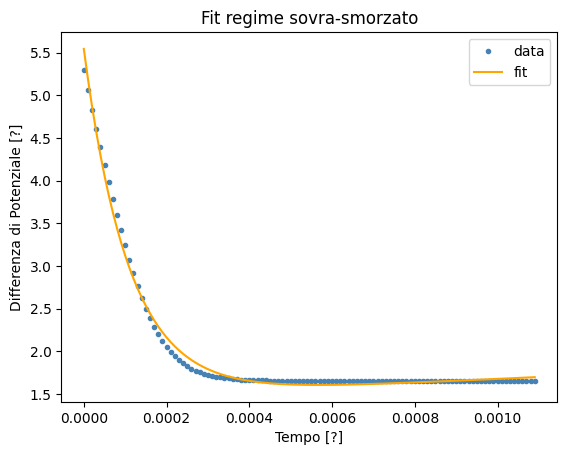

In [102]:
#VC fit over-damped
R = 2714 + r_L

alpha = R/L/2

s1 = np.sqrt(alpha*alpha - w0*w0) - alpha
s2 = -np.sqrt(alpha*alpha - w0*w0) - alpha

def over_damped_fit(x, p1, p2, a1, a2, offset):
    return  a1*np.exp(p1*(x-offset)) + a2*np.exp(p2*(x-offset))

#params
amplitude_guess = 4
offset_guess = 0.00009

P0 = [s1, s2, amplitude_guess, amplitude_guess, offset_guess]

file = "./data/RLC_sovrasmorzato.txt"
temp = np.loadtxt(file, unpack = True)
x = temp[4]
y = temp[5]

print("index:", x[100])

#cropping data for fit:
x = x[130:240] - x[130]
y = y[130:240]

#todo: why does this not change anything from the fit?
popt, pcov = curve_fit(over_damped_fit, x, y, sigma = std, p0 = P0)
#popt, pcov = curve_fit(over_damped_fit, x, y, p0 = P0)

fig, axes = plt.subplots()

plt.plot(x,y, '.', color = 'steelblue', label = "data")
         

plt.plot(x,over_damped_fit(x, *popt), color = 'orange', label = "fit")
plt.xlabel("Tempo [?]")
plt.ylabel("Differenza di Potenziale [?]")
plt.title("Fit regime sovra-smorzato")
axes.legend()
print("parameters:\n", popt)
print("covariance matrix:\n",pcov)

#todo: verify it is error
errors = np.sqrt(np.diag(pcov))
print("expected value parameter s1: ", s1, "\nvalue extracted from fit: ", popt[0], " +/- ", errors[0])
print("expected value parameter s2: ", s2, "\nvalue extracted from fit: ", popt[1], " +/- ", errors[1])

In [103]:
#extracting L and C from fit and R:
def from_params_to_RLC(par1, par2, R):
    alpha = -(par1 + par2)/2
    w0 = np.sqrt(((s1 + alpha)**2 -alpha*alpha))
    L = R/alpha/2
    C = 1/(w0*w0)/L
    print("L: ",L)
    print("C:",C)

from_params_to_RLC(popt[0], popt[1], R)

L:  0.30130333132382375
C: 6.821029461861238e-08


0.00024118400828724708
0.0025
parameters:
 [2.00880745e+04 2.87477171e+03 4.78668252e+00 9.78450384e-02]
covariance matrix:
 [[ 5.35110772e+03 -6.30351875e+02 -1.05653072e+00 -9.68046433e-01]
 [-6.30351875e+02  4.53344893e+03  3.42899472e+00  2.11976646e-01]
 [-1.05653072e+00  3.42899472e+00  5.68270281e-03  3.55009681e-04]
 [-9.68046433e-01  2.11976646e-01  3.55009681e-04  3.22784847e-04]]
expected value parameter beta:  26051.417553755855 
value extracted from fit:  20088.074501967392  +/-  73.15126602162044
expected value parameter alpha:  21320.649132624512 
value extracted from fit:  2874.7717099622005  +/-  67.3308913638139


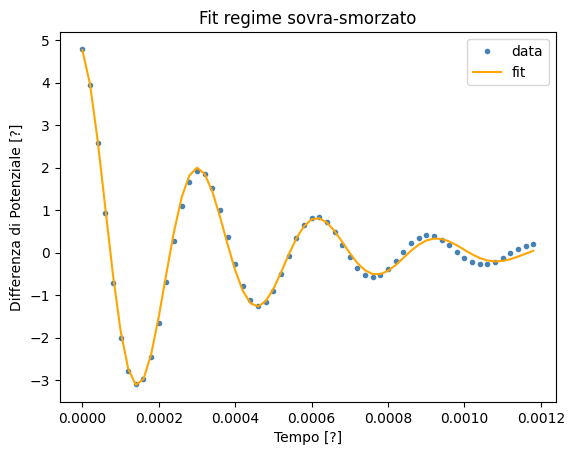

In [104]:
#under damped regime fit of VL
R = 1143
alpha = R/L/2

beta = np.sqrt(w0*w0 - alpha*alpha)

period = 2*np.pi/(beta)
#period of square signal
square_period = 1/(f)
print(period)
#periodo osservato  circa 0.0002
print(square_period)

def under_damped_fit(x,beta,alpha,a,phi):
    return a*np.cos(beta*x+phi)*np.exp(-alpha*x)

#initial parameters
amplitude_guess = 5
phi_guess = 0.01
P0 = [beta,alpha,amplitude_guess,phi_guess]

file = "./data/RLC_sottosmorzato.txt"
temp = np.loadtxt(file, unpack = True)
x = temp[2]
y = temp[3]

#cropping data for fit:
x = x[0:60]
y = y[0:60]

#todo: why does this not change anything from the fit?
popt, pcov = curve_fit(under_damped_fit, x, y, sigma = std, p0 = P0)
#popt, pcov = curve_fit(over_damped_fit, x, y, p0 = P0)

fig, axes = plt.subplots()

plt.plot(x,y, '.', color = 'steelblue', label = "data")
         

plt.plot(x,under_damped_fit(x, *popt), color = 'orange', label = "fit")
plt.xlabel("Tempo [?]")
plt.ylabel("Differenza di Potenziale [?]")
plt.title("Fit regime sovra-smorzato")
axes.legend()
print("parameters:\n", popt)
print("covariance matrix:\n",pcov)

#todo: verify it is error
errors = np.sqrt(np.diag(pcov))
print("expected value parameter beta: ", beta, "\nvalue extracted from fit: ", popt[0], " +/- ", errors[0])
print("expected value parameter alpha: ", alpha, "\nvalue extracted from fit: ", popt[1], " +/- ", errors[1])

parameters:
 [ 4.79785349e+04  1.06117922e+07 -8.48012158e+02]
covariance matrix:
 [[ 3.43847598e+07  5.65690830e+10 -4.95173386e+06]
 [ 5.65690830e+10  9.46270732e+13 -8.31225862e+09]
 [-4.95173386e+06 -8.31225862e+09  7.30860149e+05]]
expected value parameter alpha:  23074.053348255922 
value extracted from fit:  47978.53490761915  +/-  5863.851954997637


/var/folders/bd/5ss8qyms4cd6_t67dg1pjhbw0000gn/T/ipykernel_7836/46246795.py:7: RuntimeWarning: overflow encountered in exp
  return (x*a1 + a2)*np.exp(-alpha*x)


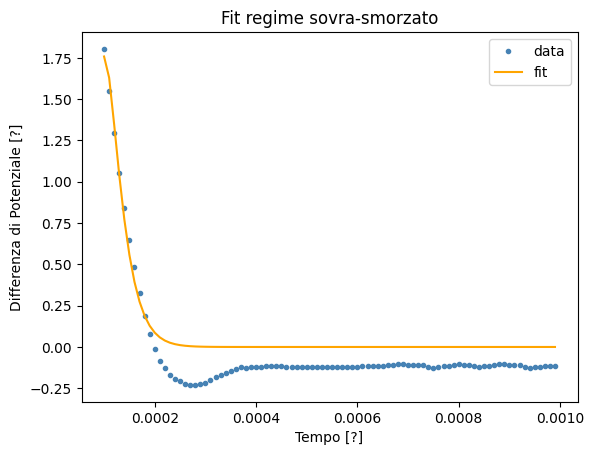

In [105]:
#Critical damping on VR
R = 1237

alpha = R/L/2

def critical_fit(x,alpha,a1,a2):
    return (x*a1 + a2)*np.exp(-alpha*x)

#initial parameters
amplitude1_guess = 5
amplitude2_guess = 0.01
P0 = [alpha,amplitude1_guess,amplitude2_guess]

file = "./data/RLC_critico1.txt"
temp = np.loadtxt(file, unpack = True)
x = temp[6]
y = temp[7]

#cropping data for fit:
x = x[10:100]
y = y[10:100]

#todo: why does this not change anything from the fit?
popt, pcov = curve_fit(critical_fit, x, y, sigma = std, p0 = P0)
#popt, pcov = curve_fit(over_damped_fit, x, y, p0 = P0)

fig, axes = plt.subplots()

plt.plot(x,y, '.', color = 'steelblue', label = "data")
         

plt.plot(x,critical_fit(x, *popt), color = 'orange', label = "fit")
plt.xlabel("Tempo [?]")
plt.ylabel("Differenza di Potenziale [?]")
plt.title("Fit regime sovra-smorzato")
axes.legend()
print("parameters:\n", popt)
print("covariance matrix:\n",pcov)

#todo: verify it is error
errors = np.sqrt(np.diag(pcov))
print("expected value parameter alpha: ", alpha, "\nvalue extracted from fit: ", popt[0], " +/- ", errors[0])

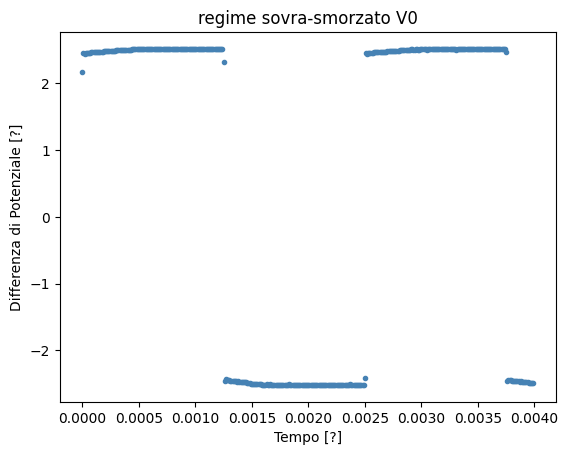

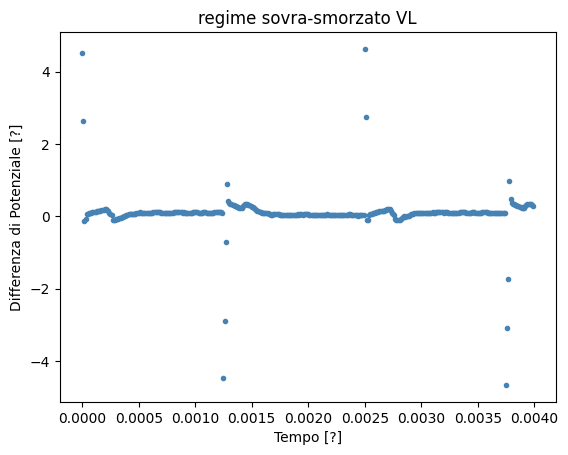

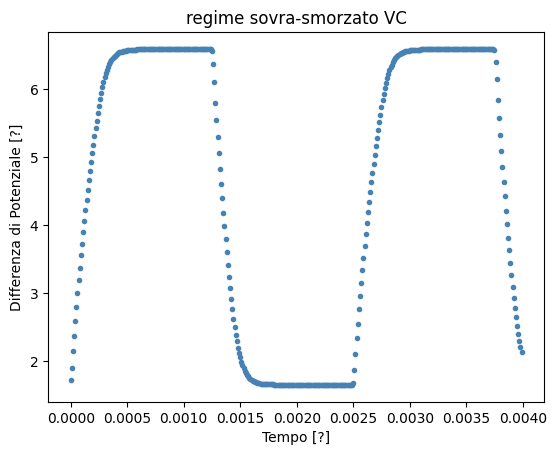

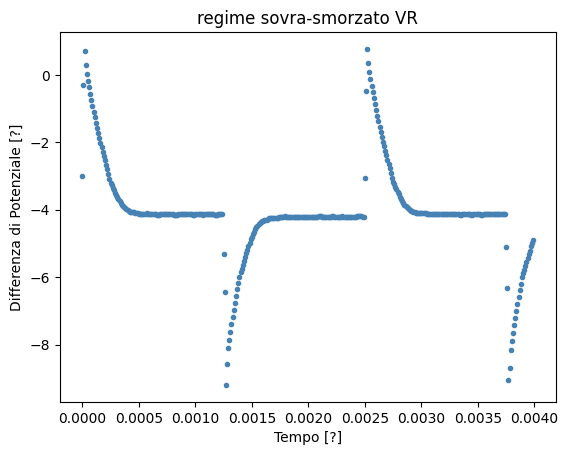

In [106]:
#showing over damped histos
file = "./data/RLC_sovrasmorzato.txt"

plot_names = ["V0", "VL", "VC", "VR"]
data_matrix = np.loadtxt(file, unpack = True)

#plots
for i in range(4):
    x  = data_matrix[2*i]
    y  = data_matrix[2*i+1]

    fig, axes = plt.subplots()
    
    plt.plot(x,y, '.', color = 'steelblue', label = "data")
    plt.xlabel("Tempo [?]")
    plt.ylabel("Differenza di Potenziale [?]")
    plt.title("regime sovra-smorzato " + plot_names[i])

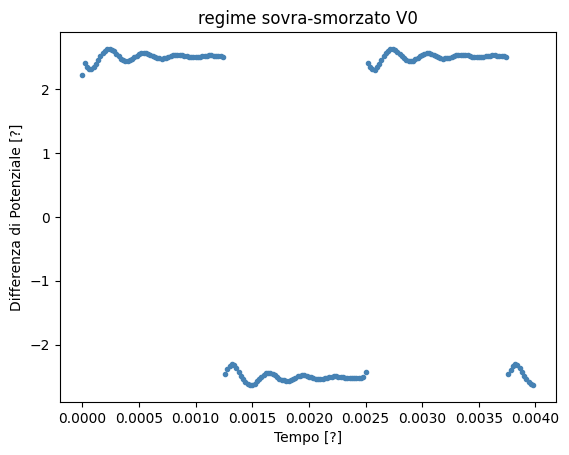

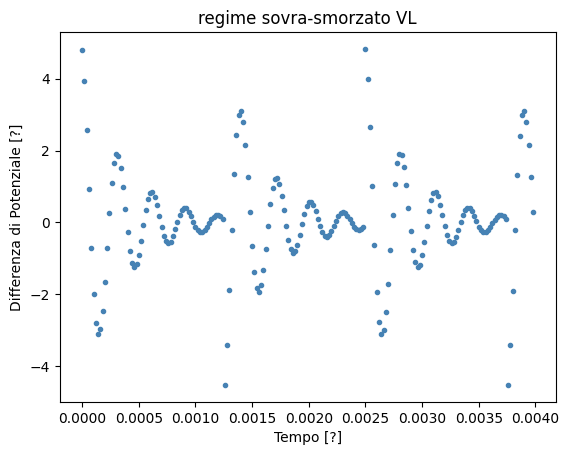

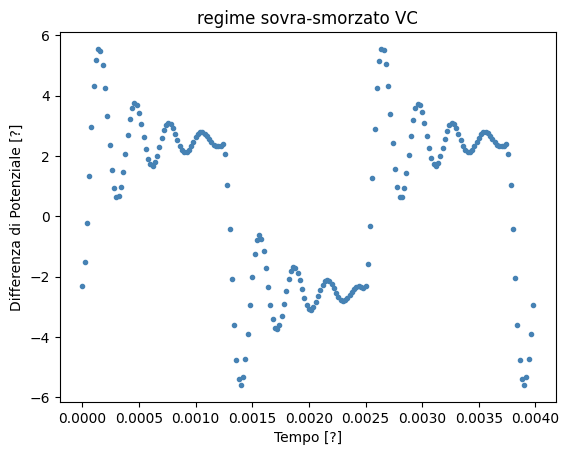

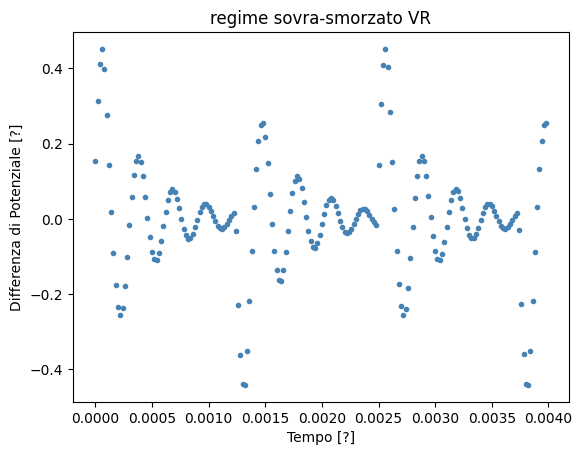

In [107]:
#showing under damped histos
file = "./data/RLC_sottosmorzato.txt"

plot_names = ["V0", "VL", "VC", "VR"]
data_matrix = np.loadtxt(file, unpack = True)

#plots
for i in range(4):
    x  = data_matrix[2*i]
    y  = data_matrix[2*i+1]

    fig, axes = plt.subplots()
    
    plt.plot(x,y, '.', color = 'steelblue', label = "data")
    plt.xlabel("Tempo [?]")
    plt.ylabel("Differenza di Potenziale [?]")
    plt.title("regime sovra-smorzato " + plot_names[i])

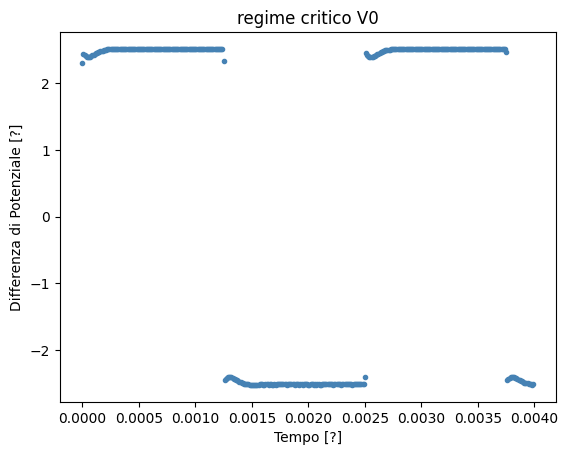

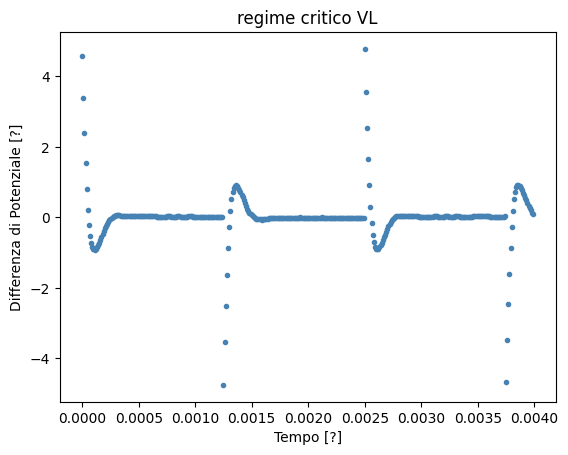

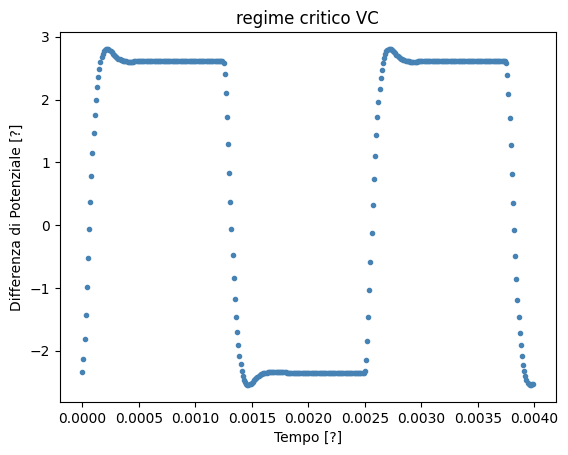

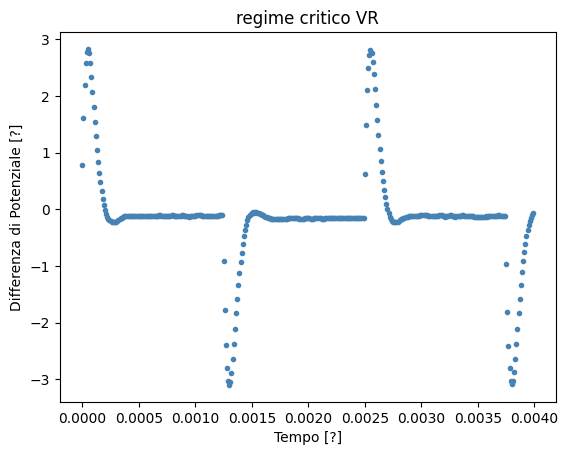

In [108]:
#showing critival damping histos
file = "./data/RLC_critico1.txt"

plot_names = ["V0", "VL", "VC", "VR"]
data_matrix = np.loadtxt(file, unpack = True)
 
#plots
for i in range(4):
    x  = data_matrix[2*i]
    y  = data_matrix[2*i+1]

    fig, axes = plt.subplots()
    
    plt.plot(x,y, '.', color = 'steelblue', label = "data")
    plt.xlabel("Tempo [?]")
    plt.ylabel("Differenza di Potenziale [?]")
    plt.title("regime critico " + plot_names[i])